In [1]:
# ! pip install pyoso

In [2]:
from dotenv import load_dotenv
import os
import pandas as pd
from pyoso import Client
import plotly.graph_objects as go

load_dotenv()

OSO_API_KEY = os.environ['OSO_API_KEY']
client = Client(api_key=OSO_API_KEY)

## Queries

In [3]:
df_tvl = client.to_pandas("""

SELECT
  p.display_name,
  e.bucket_day,
  SUM(CASE WHEN from_artifact_namespace = 'zksync_era' THEN amount ELSE 0 END) AS zksync_era_tvl,
  SUM(CASE WHEN from_artifact_namespace != 'zksync_era' THEN amount ELSE 0 END) AS other_tvl
FROM int_events_daily_to_project__defillama_tvl AS e
JOIN projects_v1 AS p ON e.project_id = p.project_id
WHERE p.project_name IN ('izumi-finance', 'pancakeswap', 'maverickprotocol', 'woonetwork')
GROUP BY 1,2
ORDER BY 1,2
    
""")

df_tvl['bucket_day'] = pd.to_datetime(df_tvl['bucket_day']).dt.strftime('%Y-%m-%d')

In [4]:
df_gh = client.to_pandas("""

SELECT
  p.display_name AS protocol,
  m.display_name AS metric_name,
  tm.sample_date AS day,
  tm.amount AS amount
FROM timeseries_metrics_by_project_v0 AS tm
JOIN metrics_v0 AS m ON tm.metric_id = m.metric_id
JOIN projects_v1 AS p ON tm.project_id = p.project_id
JOIN sboms_v0 s ON p.project_id = s.from_project_id
WHERE
  s.to_package_artifact_name = 'zksync-ethers'
  AND m.metric_name = 'GITHUB_full_time_developers_monthly'

""")

df_gh.tail()

protocol                          metric_name         day  amount
6715         Kleros  GITHUB_full_time_developers_monthly  2018-06-01       3
6716         Kleros  GITHUB_full_time_developers_monthly  2018-06-01       3
6717         Kleros  GITHUB_full_time_developers_monthly  2018-06-01       3
6718  Remix Project  GITHUB_full_time_developers_monthly  2018-06-01       1
6719   Loom Network  GITHUB_full_time_developers_monthly  2018-06-01       3

## Charts

In [5]:
def tvl_chart(project, base_date):
    df_project = df_tvl.query("display_name == @project and bucket_day >= @base_date").copy()
    
    base_row = df_project[df_project['bucket_day'] == base_date]
    if base_row.empty:
        base_row = df_project.sort_values('bucket_day').iloc[[0]]
        print(f"⚠️ No data for {base_date}, using earliest date: {base_row['bucket_day'].values[0]} instead")

    base_values = base_row[['zksync_era_tvl', 'other_tvl']].iloc[0]

    df_project['zksync_era_tvl_norm'] = df_project['zksync_era_tvl'] / base_values['zksync_era_tvl'] * 100
    df_project['other_tvl_norm'] = df_project['other_tvl'] / base_values['other_tvl'] * 100

    if project == 'iZUMi Finance':
        df_project = df_project[df_project['bucket_day'] != '2025-02-13']

    max_val = max(df_project['zksync_era_tvl_norm'].max(), df_project['other_tvl_norm'].max())
    y_axis_max = (int(max_val // 50) + 1) * 50
    
    max_idx = df_project['zksync_era_tvl'].idxmax()
    max_row = df_project.loc[max_idx]
    max_date = max_row['bucket_day']
    max_val_norm = max_row['zksync_era_tvl_norm']
    zksync_raw = max_row['zksync_era_tvl']
    other_raw = max_row['other_tvl']
    zksync_pct = zksync_raw / (zksync_raw + other_raw) * 100

    annotation_text = f"Max zkSync TVL: ${zksync_raw:,.0f} ({zksync_pct:.1f}% of total)"

    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=df_project['bucket_day'],
        y=df_project['zksync_era_tvl_norm'],
        name='TVL on ZKsync Era',
        mode='lines',
        line=dict(width=2),
    ))

    fig.add_trace(go.Scatter(
        x=df_project['bucket_day'],
        y=df_project['other_tvl_norm'],
        name='TVL on Other Chains',
        mode='lines',
        line=dict(width=2),
    ))

    fig.add_annotation(
        x=max_date,
        y=max_val_norm,
        text=annotation_text,
        showarrow=True,
        arrowhead=2,
        ax=40,
        ay=-40,
        bgcolor='rgba(0,0,0,0.6)',
        font=dict(color='white'),
        bordercolor='black',
        borderwidth=1
    )

    fig.update_layout(
        title=dict(
            text=f"{project} TVL, normalized to {base_date}",
            x=0.01,
            xanchor='left',
            font=dict(size=20)
        ),
        font=dict(
            family="Helvetica Neue, sans-serif",
            size=14
        ),
        xaxis=dict(
            showgrid=True,
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        yaxis=dict(
            title="TVL (Normalized)",
            range=[0, y_axis_max],
            showgrid=True,
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        legend=dict(
            x=1.0,
            y=1.0,
            bgcolor='rgba(255,255,255,0)',
            borderwidth=0
        ),
        margin=dict(t=50, b=40, l=60, r=40)
    )

    fig.show()

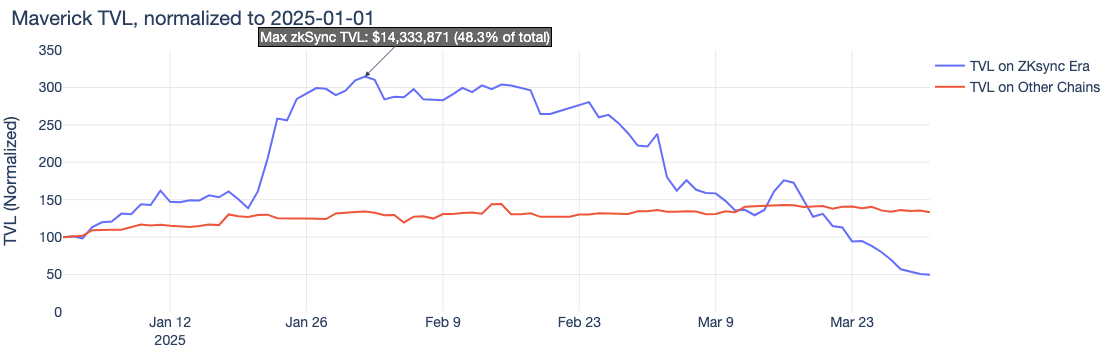

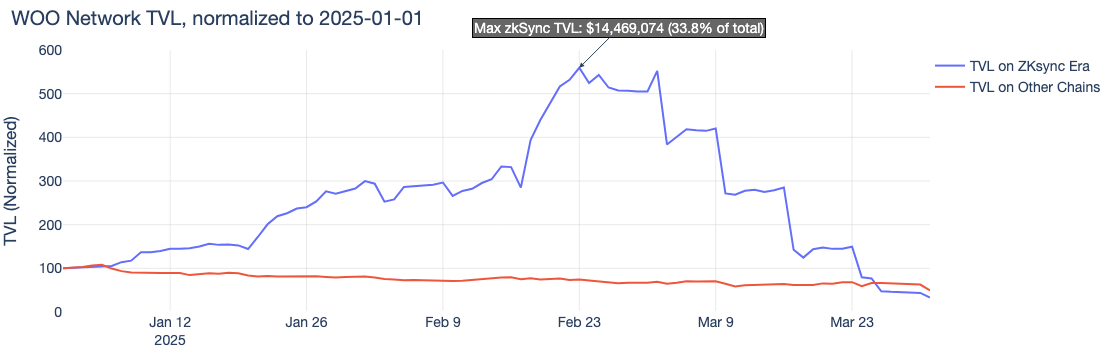

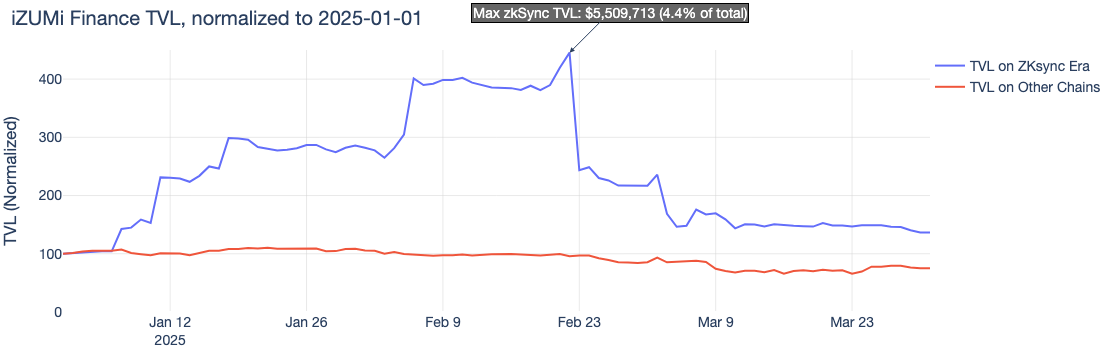

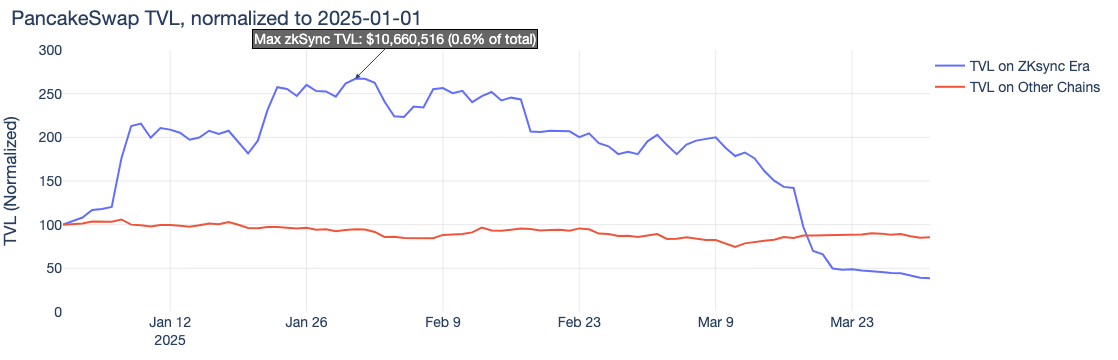

In [6]:
for p in ['Maverick', 'WOO Network', 'iZUMi Finance', 'PancakeSwap']:
    tvl_chart(p, '2025-01-01')

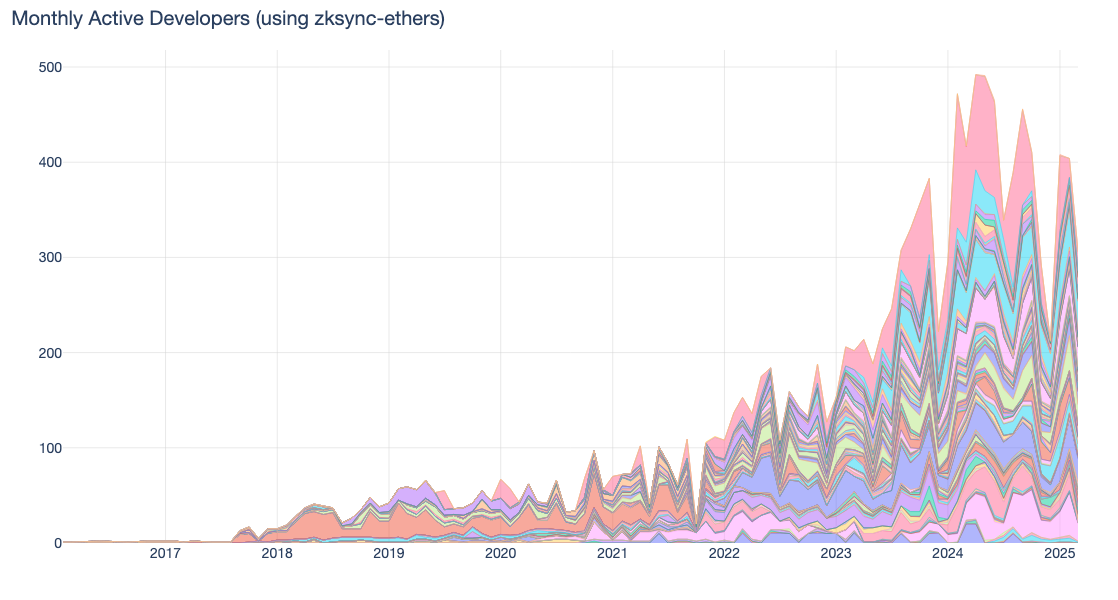

In [7]:
def plot_active_devs(df):
    fig = go.Figure()

    df['day'] = pd.to_datetime(df['day'])
    df = df.sort_values(['day', 'protocol'])

    df_pivot = df.pivot_table(index='day', columns='protocol', values='amount', aggfunc='sum').fillna(0)
    df_pivot = df_pivot.sort_index()

    for protocol in df_pivot.columns:
        fig.add_trace(go.Scatter(
            x=df_pivot.index,
            y=df_pivot[protocol],
            mode='lines',
            name=protocol,
            stackgroup='one',
            line=dict(width=0.5),
        ))

    fig.update_layout(
        title=dict(
            text="Monthly Active Developers (using zksync-ethers)",
            x=0.01,
            xanchor='left',
            font=dict(size=20)
        ),
        font=dict(
            family="Helvetica Neue, sans-serif",
            size=14
        ),
        xaxis=dict(
            title="",
            showgrid=True,
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        yaxis=dict(
            title="",
            showgrid=True,
            gridcolor='lightgray',
            gridwidth=0.5
        ),
        plot_bgcolor='white',
        paper_bgcolor='white',
        showlegend=False,
        margin=dict(t=50, b=40, l=60, r=40),
        height=600,
        width=800
    )

    fig.show()

plot_active_devs(df_gh)